### Exercise 1 (Universal Thresholding). 
Consider the model
$$
Y_i=\alpha_i+\epsilon_i, \quad i=1, \ldots, n,
$$

where the noise terms $\epsilon_i$ are iid distributed as $\mathcal{N}\left(0, \sigma^2\right)$. We estimate the unknown signal coefficients $\boldsymbol{\alpha}$ using the hard-thresholding rule

$$
\hat{\alpha}_i=\eta_\lambda\left(Y_i\right) \quad \text { with } \quad \eta_\lambda(y)= \begin{cases}y, & |y|>\lambda \\ 0, & \text { otherwise }\end{cases}
$$


In this exercise, we analyze the universal threshold proposed by Donoho and Johnstone: $\lambda_n= \sigma \sqrt{2 \log n}$.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

1. Implement a function that generates data for different sparsity levels $s$, corresponding to the number of nonzero entries in the true vector $\mathbf\alpha$. The nonzero coefficients should have amplitude proportional to a fixed signal-to-noise ratio (SNR).

In [ ]:
def generate_data(n: int, s: int = 0, snr: float = 4) -> tuple[np.ndarray, np.ndarray]:
    alpha_true = np.zeros(n)
    if s > 0:
        non_zero_indices = np.random.choice(n, s, replace=False)
        alpha_true[non_zero_indices] = snr
    epsilon = np.random.randn(n)
    Y = alpha_true + epsilon
    return Y, alpha_true

2. Using the generated data $\mathbf{Y}$, compute the hard-threshold estimator $\hat{\boldsymbol{\alpha}}$. Plot on the same figure the observed data $\mathbf{Y}$, the true coefficients $\boldsymbol{\alpha}$, and the estimated coefficients $\hat{\boldsymbol{\alpha}}$. Add horizontal lines indicating $\pm \lambda_n$, and repeat for several values of $s$ to visualize the effect of sparsity.

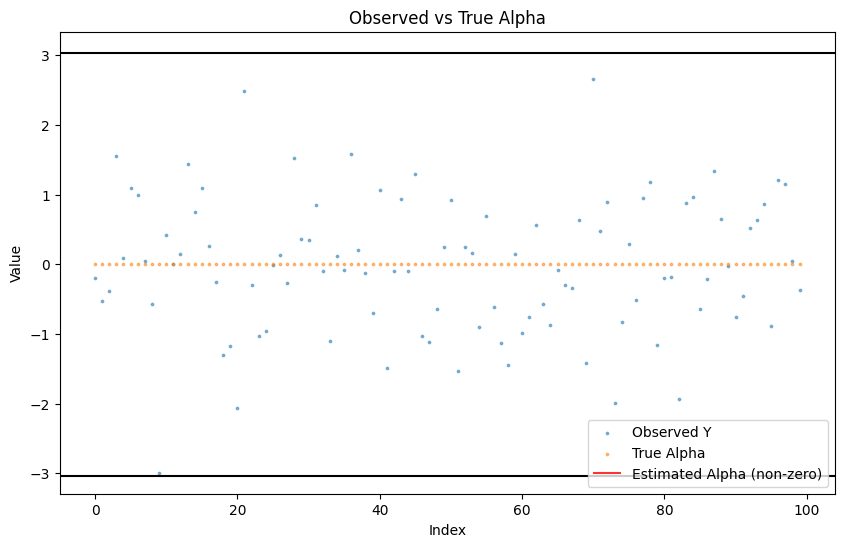

In [38]:
def hard_thresholding(Y, threshold):
    return Y * (np.abs(Y) >= threshold)

n = 100
s = 0
lambda_ = np.sqrt(2 * np.log(n))
Y, alpha_true = generate_data(n, s)
alpha_hat = hard_thresholding(Y, lambda_)

plt.figure(figsize=(10, 6))
plt.scatter(range(n), Y, label='Observed Y', alpha=0.5, s=3)
plt.scatter(range(n), alpha_true, label='True Alpha', alpha=0.5, s=3)
nonzero_indices = np.where(alpha_hat != 0)[0]
plt.vlines(nonzero_indices, ymin=0, ymax=alpha_hat[nonzero_indices],
           color='red', alpha=0.8, label='Estimated Alpha (non-zero)')

plt.axhline(lambda_, color='black')
plt.axhline(-lambda_, color='black')
plt.legend()
plt.title('Observed vs True Alpha')
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()

3. Perform a Monte Carlo simulation to estimate

$$
\mathbb{P}(\hat{\boldsymbol{\alpha}}=\mathbf{0})
$$

under the null case $\boldsymbol{\alpha}=\mathbf{0}$, for increasing values of $n$. Show empirically that this probability tends to 1 as $n \rightarrow \infty$. Recall from TD3 that the theoretical asymptotic behaviour satisfies

$$
\mathbb{P}(\hat{\boldsymbol{\alpha}}=\mathbf{0}) \approx 1-\frac{1}{\sqrt{\pi \log n}}
$$

and plot both the simulated and theoretical curves on a $\log -\log$ scale.

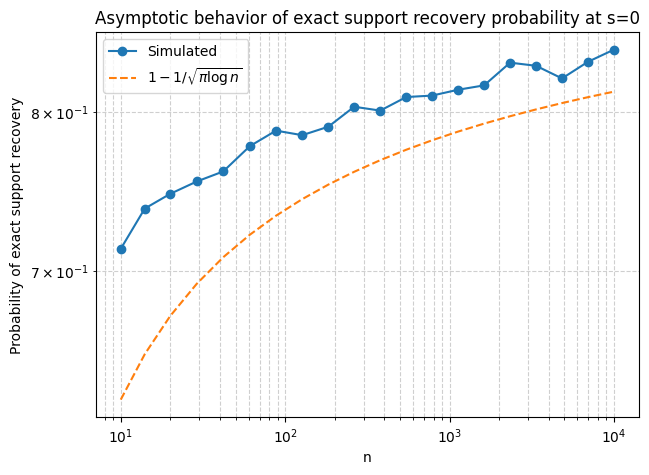

In [40]:
def prob_at_zero(n, trials=5000):
    success_count = 0
    lambda_ = np.sqrt(2 * np.log(n))
    for _ in range(trials):
        Y, _ = generate_data(n, s=0)
        alpha_hat = hard_thresholding(Y, lambda_)
        if np.all(alpha_hat == 0):
            success_count += 1
    return success_count / trials

n_values = n_values = np.logspace(1, 4, 20, dtype=int)
c = 2 / np.sqrt(2 * np.pi)
approx = c / np.sqrt(np.log(n_values))
recovery = []
for n in n_values:
    p_recovery = prob_at_zero(n, trials=5000)
    recovery.append(p_recovery)
# Plot
plt.figure(figsize=(7,5))
plt.loglog(n_values, recovery, 'o-', label='Simulated')
plt.loglog(n_values, 1-1/np.sqrt(np.pi * np.log(n_values)), '--', label=r'$1 - 1 / \sqrt{\pi \log n}$')
plt.xlabel("n")
plt.ylabel("Probability of exact support recovery")
plt.title("Asymptotic behavior of exact support recovery probability at s=0")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.6)
plt.show()

4. For fixed $n$, estimate the probability of exact support recovery (that is, the probability that $\hat{\boldsymbol{\alpha}}$ identifies exactly the same nonzero entries as $\boldsymbol{\alpha})$.Repeat the experiment for increasing values of $s$ (the true sparsity) and for several $n$. Plot the resulting phase transition curves to illustrate how recovery performance degrades as $s$ grows.

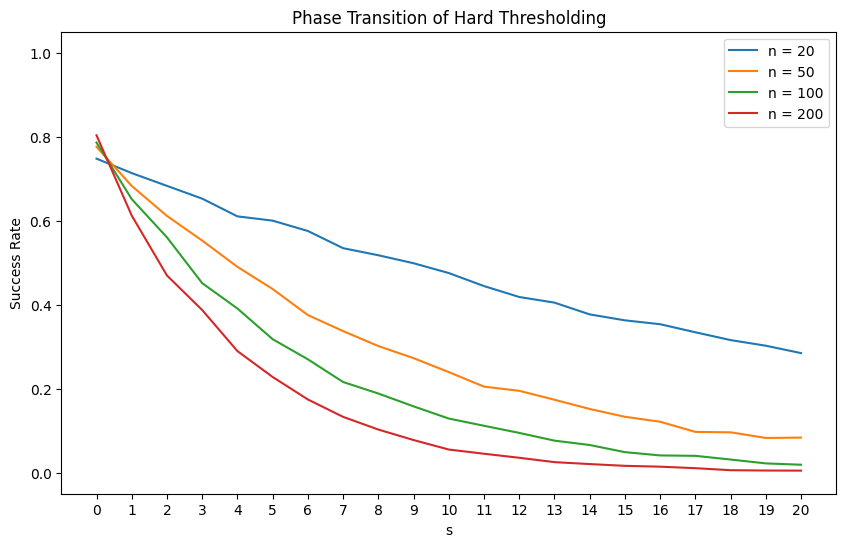

In [5]:
def phase_tranition(n, s_values, trials=5000):
    results = {}
    lambda_ = np.sqrt(2 * np.log(n))
    for s in s_values:
        success_count = 0
        for _ in range(trials):
            Y, alpha_true = generate_data(n, s)
            alpha_hat = hard_thresholding(Y, lambda_)
            true_support = (alpha_true != 0)
            hat_support = (alpha_hat != 0)
            success_count += int(np.all(true_support == hat_support))
        success_rate = success_count / trials
        results[s] = success_rate
    return results


n_values = [20, 50, 100, 200]
s_values = np.arange(21)
phase = np.zeros((len(n_values), len(s_values)))

plt.figure(figsize=(10, 6))
for i, n in enumerate(n_values):
    results = phase_tranition(n, s_values)
    plt.plot(s_values, [results[s] for s in s_values], label=f"n = {n}")
plt.xlabel("s")
plt.xticks(s_values)
plt.ylabel("Success Rate")
plt.ylim(-0.05, 1.05)
plt.title("Phase Transition of Hard Thresholding")
plt.legend()

### Exercise 2 (Hard vs. Soft Thresholding: a Bias-Variance Trade-Off). 
In the previous exercise, we analyzed the ability of the universal threshold to recover the correct support (i.e., the set of nonzero coefficients) with high probability. In this exercise, we will focus on the mean squared error (MSE) criterion instead, and compare the performance of hard and soft thresholding.

1. Generate data using the same procedure as in Exercise 1, with a fixed number of nonzero coefficients $s$, and apply both hard and soft thresholding using the universal threshold $\lambda_n=\sigma \sqrt{2 \log n}$. Compute the empirical MSE $$\mathrm{MSE}=\frac{1}{n}\|\hat{\boldsymbol{\alpha}}-\boldsymbol{\alpha}\|_2^2$$ for each method.

In [6]:
def soft_threshold(Y, threshold):
    return np.sign(Y) * np.maximum(np.abs(Y) - threshold, 0)

def hard_threshold(Y, threshold):
    return Y * (np.abs(Y) >= threshold)

def mse(alpha_hat, alpha_true):
    """Compute mean squared error."""
    return np.mean((alpha_hat - alpha_true)**2)

2. Repeat the experiment for different values of the nonzero coefficient amplitude (e.g., SNR $\in\{1,2,4,8\}$ ). For each SNR, estimate and plot the average MSE (over several Monte Carlo trials) for both hard and soft thresholding.

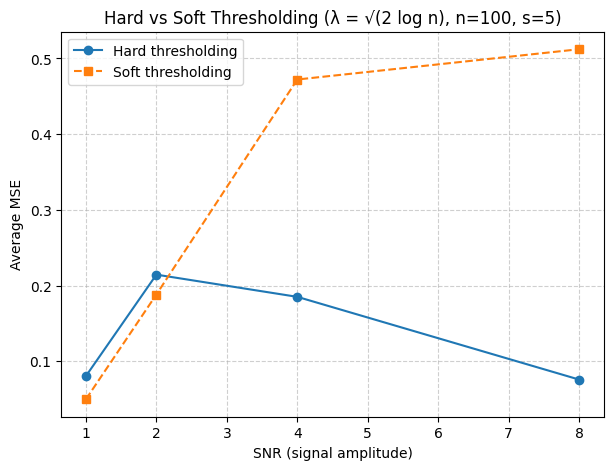

SNR= 1:  MSE_hard=0.0805,  MSE_soft=0.0498  →  Soft is better
SNR= 2:  MSE_hard=0.2144,  MSE_soft=0.1881  →  Soft is better
SNR= 4:  MSE_hard=0.1850,  MSE_soft=0.4721  →  Hard is better
SNR= 8:  MSE_hard=0.0758,  MSE_soft=0.5121  →  Hard is better


In [7]:
n = 100
s = 5
snr_values = [1, 2, 4, 8]
trials = 5000

lambda_ = np.sqrt(2 * np.log(n))
mse_hard = []
mse_soft = []

# --- 3. Monte Carlo experiment ---
for snr in snr_values:
    total_mse_hard = 0
    total_mse_soft = 0

    for _ in range(trials):
        Y, alpha_true = generate_data(n, s, snr=snr)
        alpha_hat_hard = hard_threshold(Y, lambda_)
        alpha_hat_soft = soft_threshold(Y, lambda_)
        total_mse_hard += mse(alpha_hat_hard, alpha_true)
        total_mse_soft += mse(alpha_hat_soft, alpha_true)

    mse_hard.append(total_mse_hard / trials)
    mse_soft.append(total_mse_soft / trials)

# --- 4. Plot results ---
plt.figure(figsize=(7,5))
plt.plot(snr_values, mse_hard, 'o-', label='Hard thresholding')
plt.plot(snr_values, mse_soft, 's--', label='Soft thresholding')
plt.xlabel("SNR (signal amplitude)")
plt.ylabel("Average MSE")
plt.title(f"Hard vs Soft Thresholding (λ = √(2 log n), n={n}, s={s})")
plt.legend()
plt.grid(True, ls="--", alpha=0.6)
plt.show()

# --- 5. Print summary ---
for snr, m_h, m_s in zip(snr_values, mse_hard, mse_soft):
    better = "Hard" if m_h < m_s else "Soft"
    print(f"SNR={snr:>2}:  MSE_hard={m_h:.4f},  MSE_soft={m_s:.4f}  →  {better} is better")